In [1]:
# for data handling
import pandas as pd
import numpy as np

# train-test split
from sklearn.model_selection import train_test_split

# for evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# dummy models for comparison
from sklearn.dummy import DummyRegressor

# regression models
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# for removing outliers
from scipy import stats

# for identifying best parameters
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# for visualizing the data
import seaborn as sns
import matplotlib.pyplot as plt

# to remove outerliers
from scipy import stats

# for k-fold cross validation
from sklearn.model_selection import cross_val_score, KFold

# Overview of the dataset

Here we will be using two dataset; one for the flights and one for the airports, however, these will stiched together later.

In [3]:
flight_df = pd.read_csv('flights.csv', dtype={'DESTINATION_AIRPORT': str, 'ORIGIN_AIRPORT': str})
airports_df = pd.read_csv('airports.csv')

We make copies, such that we don't risk altering the original file

In [4]:
f_df = flight_df.copy()
a_df = airports_df.copy()

We check the dimensions and take a look at the main dataset, flights.csv

In [4]:
f_df.shape

(5819079, 31)

In [5]:
f_df.head(5)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


We make a quick heatmap to get some initial insight into what features impact eachother, most importantly which of the impact the target variable.

We also drop quite a few features which aren't numerical as these can't be incorporated into the heatmap.


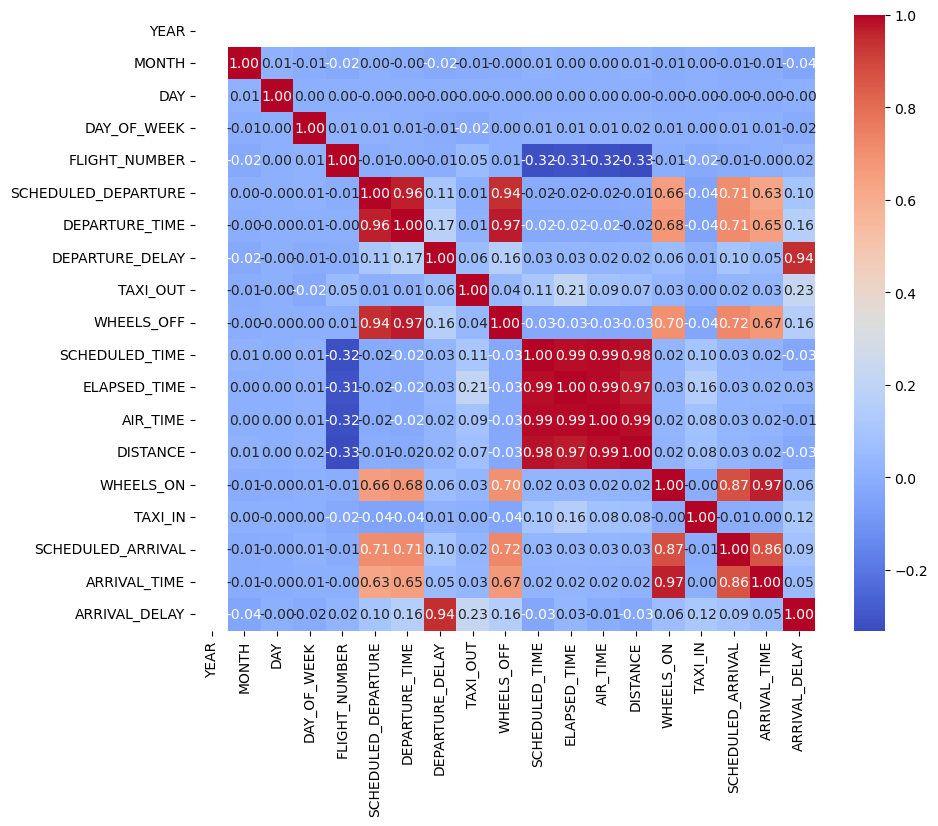

In [5]:
# drop non-numerical values
f_df_heat = f_df.drop(['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'TAIL_NUMBER', 'DIVERTED','CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY',
                   'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'], axis=1)


plt.figure(figsize=(10, 8))
    
correlation_matrix = f_df_heat.corr()

# plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")

plt.show()

This show a clear correlation between departure delay and arrival delay, which is ofcourse due to their sequential relationship. 



# Data cleaning & preprocessing

Based on the buisness case itself, it is decided that the target prediction, thereyby the target variable for this predictive model will be the delay at arrival, making ARRIVAL_DELAY our target variable.

It should then be considered what features (columns) are relevant to this.

Firstly, DIVERTED or CANCELLED flights will not be considered as part of the scope meaning these variables are removed including CANCELLATION_REASON.

Secondly, any variable which will not be available to model before a prediction should be removed as it would be senseless
to train the model on variables it will not be able to use for actual predictions.
This includes several features, including some which show strong correlation with the target variable:
- DEPARTURE_TIME (We cannot know the actual departure time before the departure occurs, only the scheduled time)
- DEPARTURE_DELAY (We cannot know the delay of departure before a delay occurs)
- TAXI_OUT (We cannot know this before it occurs)
- WHEELS_OFF (We cannot know the exact time of take-off before it occurs)
- ELAPSED_TIME and AIR_TIME (We cannot know actual total time or air time before the flight has landed)
- WHEELS_ON (We cannot know this before the flight actually lands)
- TAXI_IN (We cannot know this until it occurs)
- ARRIVAL_TIME (We cannot know this before it occurs - it is partly what we're attempting to predict)
- All delay reasons will also be removed which includes: AIR_SYSTEM_DELAY, SECURITY_DELAY, AIRLINE_DELAY, LATE_AIRCRAFT_DELAY and WEATHER_DELAY

Next, we should also remove features which give little to know useful information for potential models:
- YEAR (All data is in 2015 meaning this gives no usefull information) 
- FLIGHT_NUMBER and TAIL_NUMBER (This is highly specific but could POTENTIALLY be interesting for further research as flights who are of the same model or doing a specific route could be more likely to be delayed, but for now it might just add uneeded complexity to the dataframe)
- DISTANCE (This gives pretty much the same information as SCHEDULED_TIME, we've simply decided that the latter might prove more useful to a model than the former)




In [7]:
# drop all columns that are not relevant to a model
f_df = f_df.drop(['YEAR', 'DEPARTURE_DELAY', 'DEPARTURE_TIME', 'TAXI_OUT','WHEELS_OFF', 'ELAPSED_TIME', 'AIR_TIME',
                  'WHEELS_ON','TAXI_IN','ARRIVAL_TIME','DIVERTED','CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY',
                   'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'TAIL_NUMBER',
                  'FLIGHT_NUMBER', 'DISTANCE'], axis=1)


Removing all this still leaves us with quite a few features, including: AIRLINES, ORIGIN_AIRPORT & DESTINATION_AIRPORT.

Since we're doing regression these should be encoded to numeric values, which will turn them into features (columns). But this large number of features might introduce unwanted complexity to any models since this encoding (which is gonna have to be a one-hot encoding due to the non-hierachial relation between the categorial values otherwise we would've been able to do label-encoding) is gonna create around 600 new feaures (columns).

In order to reduce this we're gonna attach the airports.csv dataframe to the flights.csv dataframe. Then we map the origin and destination airports to their respective states and make to new features (columns) called ORIGIN_STATE & DESTINATION_STATE. This will reduce the 600 features from encoding to just 128.


In [8]:
# merge the 2 dataframes and make the state into origin states
f_df = pd.merge(f_df, a_df, left_on='ORIGIN_AIRPORT', right_on='IATA_CODE', how='left')
f_df = f_df.rename(columns={'STATE': 'ORIGIN_STATE'})
f_df = f_df.drop(columns=['IATA_CODE'])

# merge the 2 dataframes and make the state into destination states
f_df = pd.merge(f_df, a_df, left_on='DESTINATION_AIRPORT', right_on='IATA_CODE', how='left')
f_df = f_df.rename(columns={'STATE': 'DESTINATION_STATE'})
f_df = f_df.drop(columns=['IATA_CODE'])


f_df['ORIGIN_STATE'] = f_df['ORIGIN_STATE']
f_df['DESTINATION_STATE'] = f_df['DESTINATION_STATE']

# drop all of the non-informative features which came from the airports.csv dataframe as well as airports themselves
f_df = f_df.drop(['COUNTRY_x', 'LATITUDE_x', 'LONGITUDE_x', 'AIRPORT_y', 'CITY_y', 'COUNTRY_y', 'LATITUDE_y',
                  'LONGITUDE_y', 'AIRPORT_x', 'CITY_x', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT'], axis=1)


f_df.head(5)    

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,SCHEDULED_DEPARTURE,SCHEDULED_TIME,SCHEDULED_ARRIVAL,ARRIVAL_DELAY,ORIGIN_STATE,DESTINATION_STATE
0,4,7,2,EV,1340,56.0,1436,-13.0,IN,MI
1,1,24,6,AS,1910,155.0,2145,-12.0,NV,WA
2,7,8,3,WN,630,110.0,820,-8.0,CA,WA
3,5,26,2,WN,810,100.0,950,152.0,MO,TX
4,7,6,1,UA,1000,498.0,1318,-2.0,TX,HI


Another caveat, which was discovered in the flights.csv dataframe is the fact that every single airport code (LAX and such) have been turned into a rather undecodable number for every flight which occured in October of 2015. This also messes with the mapping of the 2 dataframes as all origin and destination stages are simply given as NaN's. Since the dataset consists of 5.8 million rows we've decided to simply remove all flight from October, although this might reduce the performance of potential models somewhat.

In [9]:
f_df = f_df[f_df['MONTH'] != 10]

There's also the elements of time specifically SCHEDULED_DEPARTURE and SCHEDULED_ARRIVAL. These are both show as intergers meaning that 16:05 would be 1603 and 01:30 would simply be 130. This could pose potential problems to model performance (NOTE: look into why this might be problematic) which is why we'll be splitting these 2 features into 4 - hours and minutes for each.

In [10]:
# turns it into datetime format so that it may be split up properly
f_df['SCHEDULED_DEPARTURE'] = pd.to_datetime(f_df['SCHEDULED_DEPARTURE'], format='%H%M', errors='coerce')

f_df['SCHEDULED_ARRIVAL'] = pd.to_datetime(f_df['SCHEDULED_ARRIVAL'], format='%H%M', errors='coerce')

f_df['DEPARTURE_HOUR'] = f_df['SCHEDULED_DEPARTURE'].dt.hour
f_df['DEPARTURE_MINUTE'] = f_df['SCHEDULED_DEPARTURE'].dt.minute

f_df['ARRIVAL_HOUR'] = f_df['SCHEDULED_ARRIVAL'].dt.hour
f_df['ARRIVAL_MINUTE'] = f_df['SCHEDULED_ARRIVAL'].dt.minute

# drop the old features
f_df = f_df.drop(['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL'], axis=1)


We now look at how complete the dataset is:

In [8]:
# check for missing values
missing_df = f_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(f_df.shape[0]-missing_df['missing values'])/f_df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,ARRIVAL_DELAY,101784,98.091400
1,ARRIVAL_HOUR,13559,99.745749
2,ARRIVAL_MINUTE,13559,99.745749
3,DEPARTURE_HOUR,864,99.983799
4,DEPARTURE_MINUTE,864,99.983799
5,SCHEDULED_TIME,6,99.999887
6,MONTH,0,100.000000
7,DAY,0,100.000000
8,DAY_OF_WEEK,0,100.000000
9,AIRLINE,0,100.000000


There apears to around a 100.000 missing values, which is likely to due to the diverted of cancelled flight. However, considering that this only makes up around 2% of the overall dataset it should be fine to just remove these rows.

In [17]:
f_df = f_df.dropna()

Outliers in the target variable should also be considered, since there might be some delays which should just not be included in the model due to their ridicilous values

In [11]:
# sorting by arrival delay in descending order and select the top 10
df_top_10 = f_df.sort_values(by='ARRIVAL_DELAY', ascending=False).head(10)


print(df_top_10)

         MONTH  DAY  DAY_OF_WEEK AIRLINE  SCHEDULED_TIME  ARRIVAL_DELAY  \
5741527     12   27            7      DL           107.0          124.0   
2533579      6    9            2      UA           325.0          124.0   
2683984      6   18            4      WN           120.0          124.0   
1732668      4   21            2      MQ           140.0          124.0   
497157       2    2            1      AA           105.0          124.0   
5652726     12   21            1      EV            83.0          124.0   
3102744      7   13            1      WN           150.0          124.0   
2601180      6   13            6      WN            80.0          124.0   
722811       2   17            2      AS           100.0          124.0   
3179693      7   18            6      DL           168.0          124.0   

        ORIGIN_STATE DESTINATION_STATE  DEPARTURE_HOUR  DEPARTURE_MINUTE  \
5741527           NM                UT             6.0               5.0   
2533579           CA  

This shows some flight have been delayed by almost 2000 minutes which is not realistic, we'll remove some outliers by using z-scores although there are other methods through which this can be done

In [11]:
z_scores = stats.zscore(f_df['ARRIVAL_DELAY'])
abs_z_scores = abs(z_scores)

# defining a threshold for outlier detection
threshold = 3
outliers = (abs_z_scores > threshold)

# Remove outliers
f_df = f_df[~outliers]

Finally, we'll encode the categorical features so that they can be included in the regression models and check the new dimensions of out dataframe.



In [12]:
# encoding the 3 categorial features we have
columns_to_encode = ['AIRLINE', 'ORIGIN_STATE', 'DESTINATION_STATE']

f_df = pd.get_dummies(f_df, columns=columns_to_encode,  drop_first=True)

f_df.head(5)

,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_TIME,ARRIVAL_DELAY,DEPARTURE_HOUR,DEPARTURE_MINUTE,ARRIVAL_HOUR,ARRIVAL_MINUTE,AIRLINE_AS,...,DESTINATION_STATE_TN,DESTINATION_STATE_TX,DESTINATION_STATE_UT,DESTINATION_STATE_VA,DESTINATION_STATE_VI,DESTINATION_STATE_VT,DESTINATION_STATE_WA,DESTINATION_STATE_WI,DESTINATION_STATE_WV,DESTINATION_STATE_WY
0,4,7,2,56.0,-13.0,13.0,40.0,14.0,36.0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,24,6,155.0,-12.0,19.0,10.0,21.0,45.0,1,...,0,0,0,0,0,0,1,0,0,0
2,7,8,3,110.0,-8.0,6.0,30.0,8.0,20.0,0,...,0,0,0,0,0,0,1,0,0,0
3,5,26,2,100.0,152.0,8.0,10.0,9.0,50.0,0,...,0,1,0,0,0,0,0,0,0,0
4,7,6,1,498.0,-2.0,10.0,0.0,13.0,18.0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
f_df.shape

(1757857, 128)

We still have more that 5 million rows left which should be plenty for our models - although with the large amount of features the complexity is also increased.

In [ ]:
# NOTE: this is simply a reduction of the datasize due to load time problems - the models will likely perform slightly better-
# with more data but starting at 500.000 rows is still fine
# The code should be run 1 final time with the maximum amount of rows however

f_df = f_df.sample(n=500000, random_state=42)

# Modelling

To begin applying the dataframe to various models we define our X and y, and create a train/test split. A split 70/30 will used as this one of the most common splits.

In [18]:
y = f_df['ARRIVAL_DELAY']
X = f_df.drop('ARRIVAL_DELAY', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

We will using for different models and compare there performance in order to identify the top performer.

## Linear regression

The first model is multiple linear regression, which is simply done to set a baseline for the comparison. Due to the dataframe's size and complexity this model is likely bound to perform terribly but it will, nevertheless, be compared against the other models in the Results section.

In [19]:
# define the model
f_lr = LinearRegression()

# fit the model
f_lr.fit(X_train, y_train)

# make predictions
lr_y_pred = f_lr.predict(X_test)

# calculate accuracy
print("Score on training set: {:.3f}".format(f_lr.score(X_train, y_train)))
print("Score on test set: {:.3f}".format(f_lr.score(X_test, y_test)))

# calculate Mean Squared Error
lr_mse = mean_squared_error(y_test, lr_y_pred)
print(f'Mean Squared Error: {lr_mse}')

# calculate Root Mean Squared Error
lr_rmse = mean_squared_error(y_test, lr_y_pred, squared=False)
print(f'Root Mean Squared Error: {lr_rmse}')

# calculate Mean Absolute Error
lr_mae = mean_absolute_error(y_test, lr_y_pred)
print(f'Mean Absolute Error: {lr_mae}')

Score on training set: 0.038
Score on test set: 0.038
Mean Squared Error: 575.2535367755167
Root Mean Squared Error: 23.984443641150335
Mean Absolute Error: 16.41634131208098


## K-Nearest Neighbor Regression

Next, there's KNN regression which has some hyperparameters that can be tuned via RandomSearchCV or GridSearchCV. This model might perform better or worse than linear regression but this will depend on the hyperparameters - it is also more computionally intensive than linear regression.

In [18]:
# define the model
kn = KNeighborsRegressor(n_neighbors=10, algorithm='auto', weights='distance')

# fit the model
kn.fit(X_train,y_train)

# make predictions
kn_y_pred = kn.predict(X_test)

# calculate acurracy
print("Score on training set: {:.3f}".format(kn.score(X_train, y_train)))
print("Score on test set: {:.3f}".format(kn.score(X_test, y_test)))

# calculate Mean Squared Error
kn_mse = mean_squared_error(y_test, kn_y_pred)
print(f'Mean Squared Error: {kn_mse}')

# calculate Root Mean Squared Error
kn_rmse = mean_squared_error(y_test, kn_y_pred, squared=False)
print(f'Root Mean Squared Error: {kn_rmse}')

# calculate Mean Absolute Error
kn_mae = mean_absolute_error(y_test, kn_y_pred)
print(f'Mean Absolute Error: {kn_mae}')

Score on training set: 0.999
Score on test set: -0.011
Mean Squared Error: 605.7802906665904
Root Mean Squared Error: 24.612604304839227
Mean Absolute Error: 16.951924331462546


## Random Forest Regression

Random Forest have in previous testing showed promising results relative to other models, as such we start out by attempting to hone in on its optimal parameters by using Random Search CV and Grid Search CV. This will be done on a smaller sample as this is a resource intensive process.

In [ ]:
f_df_sample = f_df.sample(n=500000, random_state=42)


y = f_df_sample['ARRIVAL_DELAY']
X = f_df_sample.drop('ARRIVAL_DELAY', axis=1)

X_sample_train, X_sample_test, y_sample_train, y_sample_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [ ]:
rf_model = rf.RandomForestRegressor()

# Parameter grid to search
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8]
}

# RandomSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,  
    scoring='r2',
    cv=4,  
    verbose=1,
    random_state=42
)


random_search.fit(X_sample_train, y_sample_train)

best_model = random_search.best_estimator_

r2_score = best_model.score(X_sample_test, y_sample_test)

print(f"Best parameters: {random_search.best_params_}")
print(f"R^2 Score: {r2_score}")

Based on the output of the Random Search we'll set appropriate parameters for out Grid Search

In [ ]:
rf_model = rf.RandomForestRegressor()

# refined parameter grid based on the results of the random search
param_grid = {
    'n_estimators': [80, 100, 120],
    'max_depth': [20, 30, 40],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [4, 8, 12]
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='r2',
    cv=4,
    verbose=1,
    return_train_score=True
)


grid_search.fit(X_sample_train, y_sample_train)

best_model = grid_search.best_estimator_

r2_score_test = best_model.score(X_sample_test, y_sample_test)

print(f"Best parameters from GridSearch: {grid_search.best_params_}")
print(f"Test R^2 Score with GridSearch: {r2_score_test}")

Random Forest Regression will likely perform better on the dataframe as it consistently shows greater results from various data and is not prone to overfitting. The hyperparameters could have a significant impact on model performance which is why RandomSearchCV or GridSearchCV should be used to determine optimal tuning settings but this is somewhat limited by the use of sample size for the cross validation.

In [19]:
# define the model with hyperparameters
rf = RandomForestRegressor(n_estimators=100, min_samples_split=2, min_samples_leaf=8, max_depth=30)

# fit the model
rf.fit(X_train, y_train)

# make predictions
rf_y_pred = rf.predict(X_test)

# calculate accuracy
print("Accuracy on training set: {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf.score(X_test, y_test)))


# calculate Mean Squared Error
rf_mse = mean_squared_error(y_test, rf_y_pred)
print(f'Mean Squared Error: {rf_mse}')

# calculate Root Mean Squared Error
rf_rmse = mean_squared_error(y_test, rf_y_pred, squared=False)
print(f'Root Mean Squared Error: {rf_rmse}')

# calculate Mean Absolute Error
rf_mae = mean_absolute_error(y_test, rf_y_pred)
print(f'Mean Absolute Error: {rf_mae}')

Accuracy on training set: 0.400
Accuracy on test set: 0.167
Mean Squared Error: 499.0198023003568
Root Mean Squared Error: 22.338751135646703
Mean Absolute Error: 15.112356847373581


## XGBoost

XGBoost have in previous testing showed promising results relative to other models as such we start out by attempting to hone in on its optimal parameters by using Random Seach CV and Grid Search CV. This will be done on a smaller sample as this is a resource intensive process.

In [ ]:
f_df_sample = f_df.sample(n=500000, random_state=42)


y = f_df_sample['ARRIVAL_DELAY']
X = f_df_sample.drop('ARRIVAL_DELAY', axis=1)

X_sample_train, X_sample_test, y_sample_train, y_sample_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [ ]:
xgb_model = xgb.XGBRegressor()

# Parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'colsample_bytree': [0.3, 0.5, 0.7, 1],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

# RandomSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50, 
    scoring='r2',
    cv=4, 
    verbose=1,
    random_state=42
)


random_search.fit(X_sample_train, y_sample_train)

best_model = random_search.best_estimator_

r2_score = best_model.score(X_sample_test, y_sample_test)

print(f"Best parameters: {random_search.best_params_}")
print(f"R^2 Score: {r2_score}")

Based on the output of the Random Search we'll set appropriate parameters for out Grid Search

In [ ]:
xgb_model = xgb.XGBRegressor()

# refined parameter grid based on the results of the random search
param_grid = {
    'n_estimators': [250, 300, 350],
    'learning_rate': [0.03, 0.05, 0.07],
    'max_depth': [7, 8, 9],
    'colsample_bytree': [0.9, 1, 1.1],
    'subsample': [0.5, 0.6, 0.7],
    'gamma': [0.1, 0.2, 0.3]
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='r2',
    cv=4,
    verbose=1,
    return_train_score=True
)


grid_search.fit(X_sample_train, y_sample_train)

best_model = grid_search.best_estimator_

r2_score_test = best_model.score(X_sample_test, y_sample_test)

print(f"Best parameters from GridSearch: {grid_search.best_params_}")
print(f"Test R^2 Score with GridSearch: {r2_score_test}")

XGBoost is a complex algorithm with a large amount of hyperparameters which can be tuned for improved performance. With the right settings either it or Random Forest will likely perform best on the dataframe. The output from the previous cross validation have further been altered manually since these methods were applied to only a subset of the data which means they should adjusted for the application of the whole dataset.

In [19]:
# define model with hyperparameters
xgbmodel = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1, learning_rate = 0.05,
                max_depth = 12, min_child_weight = 8, n_estimators = 3000, subsample = 0.7, alpha = 10)

# fit the model
xgbmodel.fit(X_train, y_train)

# make predictions
y_pred = xgbmodel.predict(X_test)

# calculate accuracy
print("Accuracy on training set: {:.3f}".format(xgbmodel.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(xgbmodel.score(X_test, y_test)))

# calculate Mean Squared Error
xgb_mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {xgb_mse}')

# calculate Root Mean Squared Error
xgb_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'Root Mean Squared Error: {xgb_rmse}')

# calculate Mean Absolute Error
xgb_mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {xgb_mae}')

KeyboardInterrupt: 

# Results and model evaluation

Displays the results in a matrix

In [ ]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'KNN', 'Random Forest', 'XGBoost'],  
    'MSE': [lr_mse, kn_mse, rf_mse, xgb_mse],  # 
    'RMSE': [lr_rmse, kn_rmse, rf_rmse, xgb_rmse],  
    'MAE': [lr_mae, kn_mae, rf_mae, xgb_mae] 
})

results

## K-fold cross validation

We'll do a k-fold cross validation for Random Forest then XGBoost to see if the results were compromised due to the train test split. This will done on a sample size due to the resource intesive nature of this task.

In [ ]:
f_df_sample = f_df.sample(n=500000, random_state=42)


y = f_df_sample['ARRIVAL_DELAY']
X = f_df_sample.drop('ARRIVAL_DELAY', axis=1)

X_sample_train, X_sample_test, y_sample_train, y_sample_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [ ]:
rf = RandomForestRegressor(n_estimators=100, min_samples_split=2, min_samples_leaf=8, max_depth=30)

# performing K-fold cross-validation
scores = cross_val_score(rf, X_sample_train, y_sample_train, scoring='r2', cv=4)

# calculating the average performance 
average_score = np.mean(scores)


print("Average R-squared Score:", average_score)
print("R-squared Scores for each fold:", scores)

Now for XGB

In [ ]:
xgbmodel = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 1, learning_rate = 0.05,
                max_depth = 12, min_child_weight = 8, n_estimators = 3000, subsample = 0.7, alpha = 10)

# performing K-fold cross-validation
scores = cross_val_score(xgbmodel, X_sample_train, y_sample_train, scoring='r2', cv=4)

# calculating the average performance 
average_score = np.mean(scores)


print("Average R-squared Score:", average_score)
print("R-squared Scores for each fold:", scores)